In [23]:
%cd /root/sagemaker/notebooks/

/root/sagemaker/notebooks


In [24]:
import datetime
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role

BUCKET = 'sagemaker-churn-20220310'
PREFIX = 'mnist'
LOCAL_DATA_DIRECTORY = f'../data/{PREFIX}'
print(f"Artifacts will be written to s3://{BUCKET}/{PREFIX}")

sagemaker_session = sagemaker.Session()
boto_session = sagemaker_session.boto_session
sagemaker_client = boto_session.client('sagemaker')
role = get_execution_role()

Artifacts will be written to s3://sagemaker-churn-20220310/mnist


In [25]:
from smexperiments.experiment import Experiment

Experiment?

Init signature: Experiment(sagemaker_boto_client, **kwargs)
Docstring:     
An Amazon SageMaker experiment, which is a collection of related trials.

New experiments are created by calling :meth:`~smexperiments.experiment.Experiment.create`. Existing
experiments can be reloaded by calling :meth:`~smexperiments.experiment.Experiment.load`. You can
add a new trial to an Experiment by calling :meth:`~smexperiments.experiment.Experiment.create_trial`.
To remove an experiment and associated trials, trial components by calling :meth:`~smexperiments.experiment
.Experiment.delete_all`.

Examples:
    .. code-block:: python

        from smexperiments import experiment

        my_experiment = experiment.Experiment.create(experiment_name='AutoML')
        my_trial = my_experiment.create_trial(trial_name='random-forest')

        for exp in experiment.Experiment.list():
            print(exp)
        for trial in my_experiment.list_trials():
            print(trial)

        my_experiment.delete

In [26]:
from smexperiments.trial import Trial

Trial?

Init signature: Trial(sagemaker_boto_client, **kwargs)
Docstring:     
An execution of a data-science workflow with an experiment.

Consists of a list of trial component objects, which document individual activities within the workflow.

Examples:
    .. code-block:: python

        from smexperiments import trial, experiment, tracker

        my_experiment = experiment.Experiment.create(experiment_name='AutoML')
        my_trial = trial.Trial.create('AutoML')

        my_tracker = tracker.Tracker.create()
        # log hyper parameter of learning rate
        my_tracker.log_parameter('learning_rate', 0.01)
        my_trial.add_trial_component(my_tracker)

        for trial_component in my_trial.list_trial_components():
            print(trial_component)

        my_trial.remove_trial_component(my_tracker)
        my_trial.delete()

Attributes:
    trial_name (str): The name of the trial.
    experiment_name (str): The name of the trial's experiment.
    tags (List[dict[str, str]]): A 

In [27]:
from smexperiments.trial_component import TrialComponent

TrialComponent?

Init signature: TrialComponent(sagemaker_boto_client, **kwargs)
Docstring:     
This class represents a SageMaker trial component object.

A trial component is a stage in a trial.

Trial components are created automatically within the SageMaker runtime and may not be created directly.
To automatically associate trial components with a trial and experiment supply an experiment config when creating a
job. For example: https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateTrainingJob.html

Attributes:
    trial_component_name (str): The name of the trial component. Generated by SageMaker from the name of the
        source job with a suffix specific to the type of source job.
    trial_component_arn (str): The ARN of the trial component.
    display_name (str): The name of the trial component that will appear in UI, such as SageMaker Studio.
    source (obj): A TrialComponentSource object with a source_arn attribute.
    status (str): Status of the source job.
    start_time (datetime

In [28]:
training_data_bucket = f'sagemaker-sample-data-{boto_session.region_name}'
training_data_prefix = 'tensorflow/mnist'

training_data_uri = f's3://{training_data_bucket}/{training_data_prefix}'
training_data_uri

's3://sagemaker-sample-data-us-east-1/tensorflow/mnist'

In [29]:
boto_session.client('s3').list_objects(
Bucket = training_data_bucket,
Prefix = training_data_prefix)

{'ResponseMetadata': {'RequestId': 'JN2QE1MHQQ5E0SYC',
  'HostId': 'kt3X6e5QEvwaOVBp8W7hczUatFsfEV4Buewu9HBbViAZhX8k0LgDOUJHah+VrhyZqEeZC00YCjQ=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'kt3X6e5QEvwaOVBp8W7hczUatFsfEV4Buewu9HBbViAZhX8k0LgDOUJHah+VrhyZqEeZC00YCjQ=',
   'x-amz-request-id': 'JN2QE1MHQQ5E0SYC',
   'date': 'Tue, 15 Mar 2022 19:12:26 GMT',
   'x-amz-bucket-region': 'us-east-1',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'IsTruncated': False,
 'Marker': '',
 'Contents': [{'Key': 'tensorflow/mnist/eval_data.npy',
   'LastModified': datetime.datetime(2019, 1, 24, 23, 36, 40, tzinfo=tzlocal()),
   'ETag': '"999d245abdf1f6f45d8b516ef04367e0-4"',
   'Size': 31360128,
   'StorageClass': 'STANDARD'},
  {'Key': 'tensorflow/mnist/eval_labels.npy',
   'LastModified': datetime.datetime(2019, 1, 24, 23, 36, 40, tzinfo=tzlocal()),
   'ETag': '"bf645d8a74fbd6d63977d0709bcb99c9"',
   'Size': 40

In [31]:
!pygmentize '../scripts/tf/tensorflow_mnist.py'

import tensorflow as tf
import argparse
import os
import numpy as np
import json


def model(x_train, y_train, x_test, y_test):
    """Generate a simple model"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(x_train, y_train)
    model.evaluate(x_test, y_test)

    return model


def _load_training_data(base_dir):
    """Load MNIST training data"""
    x_train = np.load(os.path.join(base_dir, 'train_data.npy'))
    y_train = np.load(os.path.join(base_dir, 'train_labels.npy'))
    return x_train, y_train


def _load_testing_data(base_dir):
    """Load MNIST testing data"""
    x_test = np.load(os.path.join(base_dir, 'eval_data.npy'))
    y_test = np

In [32]:
experiment_name = f"tf-mnist-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"
description = "Classification of mnist using tensorflow"
tf_experiment = Experiment.create(experiment_name = experiment_name,
                                  description= description,
                                  sagemaker_boto_client = sagemaker_client)

In [33]:
trial_name = f"tf-trial-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"

tf_trial = Trial.create(trial_name=trial_name,
                       experiment_name=tf_experiment.experiment_name,
                       sagemaker_boto_client=sagemaker_client)

In [35]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(
    entry_point='../scripts/tf/tensorflow_mnist.py',
    role=role,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    code_location=f's3://{BUCKET}/{PREFIX}',
    output_path=f's3://{BUCKET}/{PREFIX}',
    base_job_name='tf-mnist',
    py_version='py3',
    framework_version='2.1.0',
    enable_sagemaker_mertics=True)

In [36]:
experiment_config = {
        "TrialName": tf_trial.trial_name,
        "TrialComponentDisplayName": "Training",
    }

# Now associate the estimator with the Experiment and Trial
tf_estimator.fit(inputs={'training': training_data_uri},
                 experiment_config=experiment_config)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: tf-mnist-2022-03-15-23-50-30-180


2022-03-15 23:50:31 Starting - Starting the training job...
2022-03-15 23:50:35 Starting - Launching requested ML instancesProfilerReport-1647388230: InProgress
.........
2022-03-15 23:52:17 Starting - Preparing the instances for training.........
2022-03-15 23:53:57 Downloading - Downloading input data...
2022-03-15 23:54:17 Training - Downloading the training image...
2022-03-15 23:54:57 Training - Training image download completed. Training in progress.2022-03-15 23:54:47,071 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2022-03-15 23:54:47,078 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-03-15 23:54:47,608 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-03-15 23:54:47,627 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-03-15 23:54:47,645 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-03-15 23:54:47,657

Tracking Distributed Hyperparameters Search with Multiple Trials

In [40]:
from matplotlib import pyplot as plt
import pandas as pd
from torchvision import datasets, transforms

%config InlineBackend.figure_format = 'retina'

In [41]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Download, load, and transform the data.
train_set = datasets.MNIST(LOCAL_DATA_DIRECTORY, train=True, transform=transform, download=True)
test_set = datasets.MNIST(LOCAL_DATA_DIRECTORY, train=False, transform=transform, download=True)

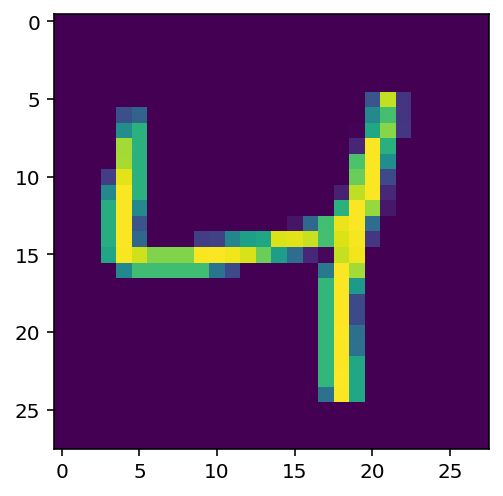

In [42]:
plt.imshow(train_set.data[2].numpy())

In [44]:
inputs = sagemaker_session.upload_data(
    path=LOCAL_DATA_DIRECTORY,
    bucket = BUCKET,
    key_prefix = PREFIX
)

In [45]:
from smexperiments.tracker import Tracker

with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sagemaker_client) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.1307,
        "normalization_std": 0.3081,
    })
    
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

In [46]:
experiment_name = f"torch-mnist-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"
description = "Classification of mnist hand-written digits with pytorch."

mnist_experiment = Experiment.create(experiment_name=experiment_name,
                                     description=description, 
                                     sagemaker_boto_client=sagemaker_client)

In [50]:
from sagemaker.pytorch import PyTorch

hidden_channel_trial_name_map = {} # Keep references to each Trial object

# If you want to run the following training jobs asynchronously, you may need to increase
# your resource limit. Otherwise, you can run them sequentially.
for i, num_hidden_channel in enumerate([2, 5, 10]):
    
    # create Trial object
    trial_name = f"torch-{num_hidden_channel}-hidden-channels-{datetime.datetime.now().strftime('%Y%m%d%H%M')}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sagemaker_client,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name
    
    # Associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(tracker.trial_component)
    
    # all input configurations, parameters, and metrics specified in estimator 
    # definition are automatically tracked
    estimator = PyTorch(
        py_version='py3',
        entry_point='../scripts/torch/pytorch_mnist.py',
        role=role,
        sagemaker_session=sagemaker_session,
        framework_version='1.6.0',
        instance_count=1,
        # If you'd prefer to use a CPU for cost, uncomment the following line instead.
        #instance_type='ml.c4.xlarge',
        instance_type='ml.m4.xlarge',
        code_location=f's3://{BUCKET}/{PREFIX}',
        output_path=f's3://{BUCKET}/{PREFIX}',
        base_job_name='torch-mnist',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': num_hidden_channel,
            'dropout': 0.2,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
        ]
    )
    
    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={'training': inputs}, 
        experiment_config={
            'TrialName': cnn_trial.trial_name,
            'TrialComponentDisplayName': 'Training',
        },
        wait=True,
    )
    
    # give it a while before dispatching the next training job
    #time.sleep(2)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: torch-mnist-2022-03-16-04-18-32-714


2022-03-16 04:18:33 Starting - Starting the training job...ProfilerReport-1647404312: InProgress
...
2022-03-16 04:19:27 Starting - Preparing the instances for training.........
2022-03-16 04:20:48 Downloading - Downloading input data...
2022-03-16 04:21:28 Training - Downloading the training image......
2022-03-16 04:22:33 Uploading - Uploading generated training modelbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-03-16 04:22:25,615 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-03-16 04:22:25,618 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-03-16 04:22:25,634 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-03-16 04:22:25,649 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-03-16 04:22:26,088 sagemaker-training-toolkit INFO     No GPUs detected (no

UnexpectedStatusException: Error for Training job torch-mnist-2022-03-16-04-18-32-714: Failed. Reason: AlgorithmError: ExecuteUserScriptError:
Command "/opt/conda/bin/python3.6 pytorch_mnist.py --backend gloo --dropout 0.2 --epochs 2 --hidden_channels 2 --optimizer sgd"
--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/logging/__init__.py", line 994, in emit
    msg = self.format(record)
  File "/opt/conda/lib/python3.6/logging/__init__.py", line 840, in format
    return fmt.format(record)
KeyError: "'time'"
Call stack:
  File "pytorch_mnist.py", line 221, in <module>
    train(args)
  File "pytorch_mnist.py", line 83, in train
    logger.debug("Distributed training - {}".format(is_distributed))
Message: 'Distributed training - False'
Arguments: ()
--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/logging/__init__.py", line 994, in emit
    msg = self.format(record)
  File "/opt/conda/lib/python3.6/logging/__init__.py", line 840, in format
    return fmt.format(record)
KeyError: "'time'"
Call stack:
  File "pytorch_mnist.py", line